In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


from datetime import datetime, date

In [58]:
# Load the CSV file into a DataFrame
df = pd.read_csv("fraud_data.csv")
df['is_fraud'] = pd.to_numeric(df['is_fraud'], errors='coerce')

# This will be data I use to train the models
data = {
    "transaction_year": [],
    "transaction_month": [],
    "transaction_day": [],
    "transaction_hour": [],
    "transaction_minute": [],
    
    "age": [],
    
    "is_fraud": df['is_fraud'].values
}

# Parse the 'trans_date_trans_time' column and extract date components
for item in df['trans_date_trans_time']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y %H:%M")
    data["transaction_year"].append(parsed_date.year)
    data["transaction_month"].append(parsed_date.month)
    data["transaction_day"].append(parsed_date.day)
    data["transaction_hour"].append(parsed_date.hour)
    data["transaction_minute"].append(parsed_date.minute)

# Parse the 'dob' column and extract date components
for item in df['dob']:
    parsed_date = datetime.strptime(item, "%d-%m-%Y")
    today = date.today()
    
    age = today.year - parsed_date.year - ((today.month, today.day) < (parsed_date.month, parsed_date.day))
    
    data["age"].append(age)

In [59]:
# 1. Compute the frequency of each merchant
merchant_counts = df['merchant'].value_counts()

"""
2. Most merchants appear too little to be able to give us information
on whether the specific merchant is correlated with fraud. I chose
30 because that is typically the smallest sample size used to get a
statistically significant result.
"""
merchants_less_than_30 = merchant_counts[merchant_counts < 30]
percentage_less_than_30 = (len(merchants_less_than_30) / len(merchant_counts)) * 100
print(f"Percentage of merchants that appear less than 30 times: {percentage_less_than_30:.2f}%")

# 3. Create a new column in df that maps the merchant frequency to each row.
df['merchant_freq'] = df['merchant'].map(merchant_counts)

# 4. Compute the correlation between merchant frequency and is_fraud
correlation = df[['merchant_freq', 'is_fraud']].corr()
print(correlation) # Weak correlation woooohooooo. Maybe will use it to create a weak learner?

# 5. Add to the data object
data['merchant_freq'] = df['merchant_freq'].values

Percentage of merchants that appear less than 30 times: 84.27%
               merchant_freq  is_fraud
merchant_freq       1.000000  0.121829
is_fraud            0.121829  1.000000


In [60]:
# WE CAN USE THE SPECIFIC CITY TO DETECT FRAUD BECAUSE THE COUNT IS OVER
# 30 FOR MOST OF THEM. HOWEVER, THAT SEEMS LIKE TOO MUCH RIGHT NOW NGL

# 1. Compute the frequency of each city
city_count = df['city'].value_counts()
state_count = df['state'].value_counts()
job_count = df['job'].value_counts()

# 2. Create a new column in df that maps cities to city frequency for each row.
df['city_freq'] = df['city'].map(city_count)
df['state_freq'] = df['state'].map(state_count)

# 3. Compute the correlation between merchant frequency and is_fraud
correlation = df[['city_freq', 'is_fraud']].corr()
print(correlation) # Weak negative correlation!!! Another weak learner!!

correlation = df[['state_freq', 'is_fraud']].corr()
print(correlation) # So weakly correlated it's useless.

# 4. Grab useful data
data['city_freq'] = df['city_freq'].values

           city_freq  is_fraud
city_freq   1.000000 -0.188793
is_fraud   -0.188793  1.000000
            state_freq  is_fraud
state_freq    1.000000 -0.015636
is_fraud     -0.015636  1.000000


In [61]:
data['city_pop'] = df['city_pop'].values
data['amt'] = df['amt'].values
data['lat'] = df['lat'].values
data['long'] = df['long'].values
data['merch_lat'] = df['merch_lat'].values
data['merch_long'] = df['merch_long'].values

data = pd.DataFrame(data)

# One hot encode cities
dummies = pd.get_dummies(df['state'], prefix='state').astype(int)
data = pd.concat([data, dummies], axis=1)

# One hot encode categories.
dummies = pd.get_dummies(df['category'], prefix='category').astype(int)
data = pd.concat([data, dummies], axis=1)

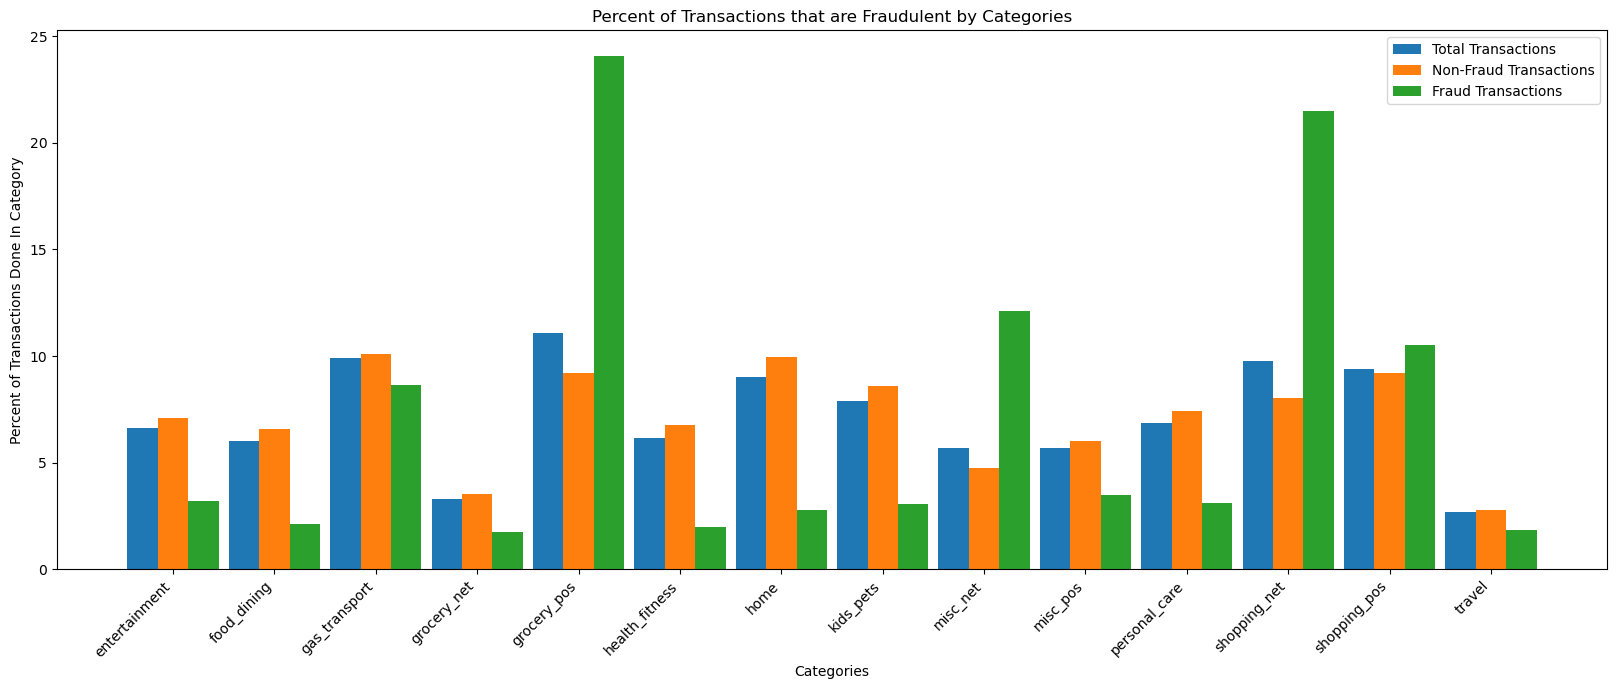

In [62]:
# Visauling Fraud by Categories
categories = df.groupby('category').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('category').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('category').size().reset_index(name='fraud_count')

categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='category', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='category', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['category']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('Categories')
plt.ylabel('Percent of Transactions Done In Category')
plt.title('Percent of Transactions that are Fraudulent by Categories')
plt.xticks(x, merged['category'], rotation=45, ha="right")  # Rotate category names for better visibility
plt.legend()
plt.show()

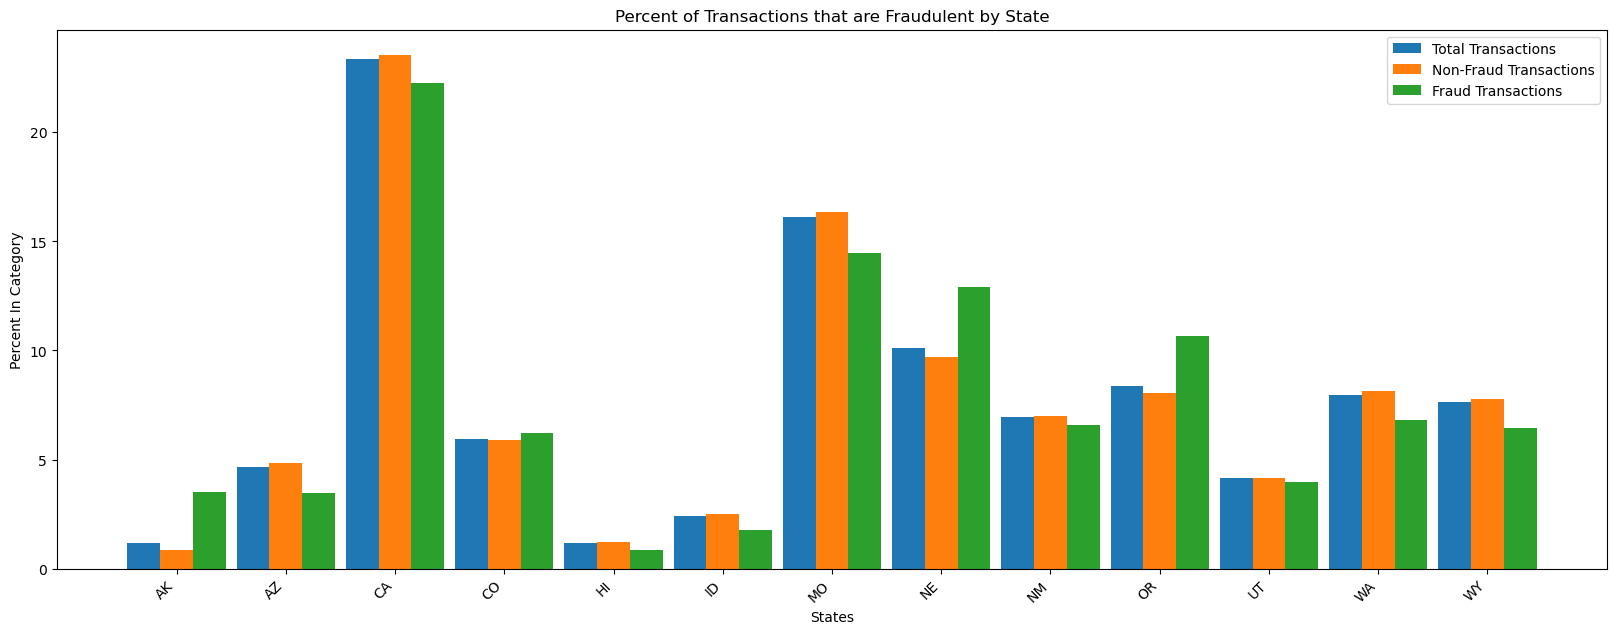

In [63]:
# Visauling Fraud by Categories
categories = df.groupby('state').size().reset_index(name='fraud_count')
nonfraud_by_categories = df[df['is_fraud'] == 0].groupby('state').size().reset_index(name='fraud_count')
fraud_by_categories = df[df['is_fraud'] == 1].groupby('state').size().reset_index(name='fraud_count')

categories['fraud_count'] = 100 * categories['fraud_count'] / categories['fraud_count'].sum()
nonfraud_by_categories['fraud_count'] = 100 * nonfraud_by_categories['fraud_count'] / nonfraud_by_categories['fraud_count'].sum()
fraud_by_categories['fraud_count'] = 100 * fraud_by_categories['fraud_count'] / fraud_by_categories['fraud_count'].sum()

# Merge data to ensure alignment across all categories
merged = categories.merge(nonfraud_by_categories, on='state', how='left', suffixes=('_total', '_nonfraud'))
merged = merged.merge(fraud_by_categories, on='state', how='left')
merged.rename(columns={'fraud_count': 'fraud_count_fraud'}, inplace=True)

# Set positions for bars
x = np.arange(len(merged['state']))  # Label locations
width = 0.3  # Width of bars

# Plot bars
plt.figure(figsize=(20, 7))
plt.bar(x - width, merged['fraud_count_total'], width=width, label='Total Transactions')
plt.bar(x, merged['fraud_count_nonfraud'], width=width, label='Non-Fraud Transactions')
plt.bar(x + width, merged['fraud_count_fraud'], width=width, label='Fraud Transactions')

# Labels and title
plt.xlabel('States')
plt.ylabel('Percent In Category')
plt.title('Percent of Transactions that are Fraudulent by State')
plt.xticks(x, merged['state'], rotation=45, ha="right")  # Rotate category names for better visibility
plt.legend()
plt.show()

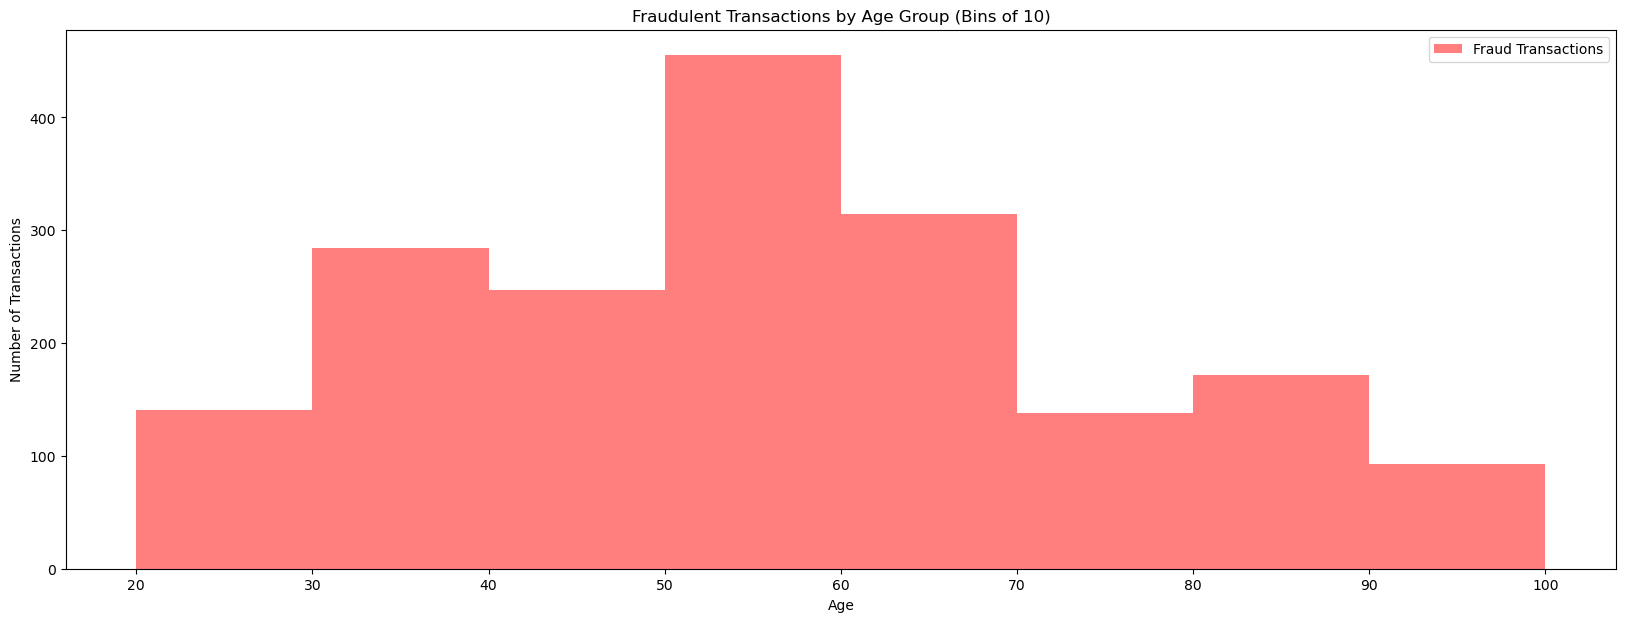

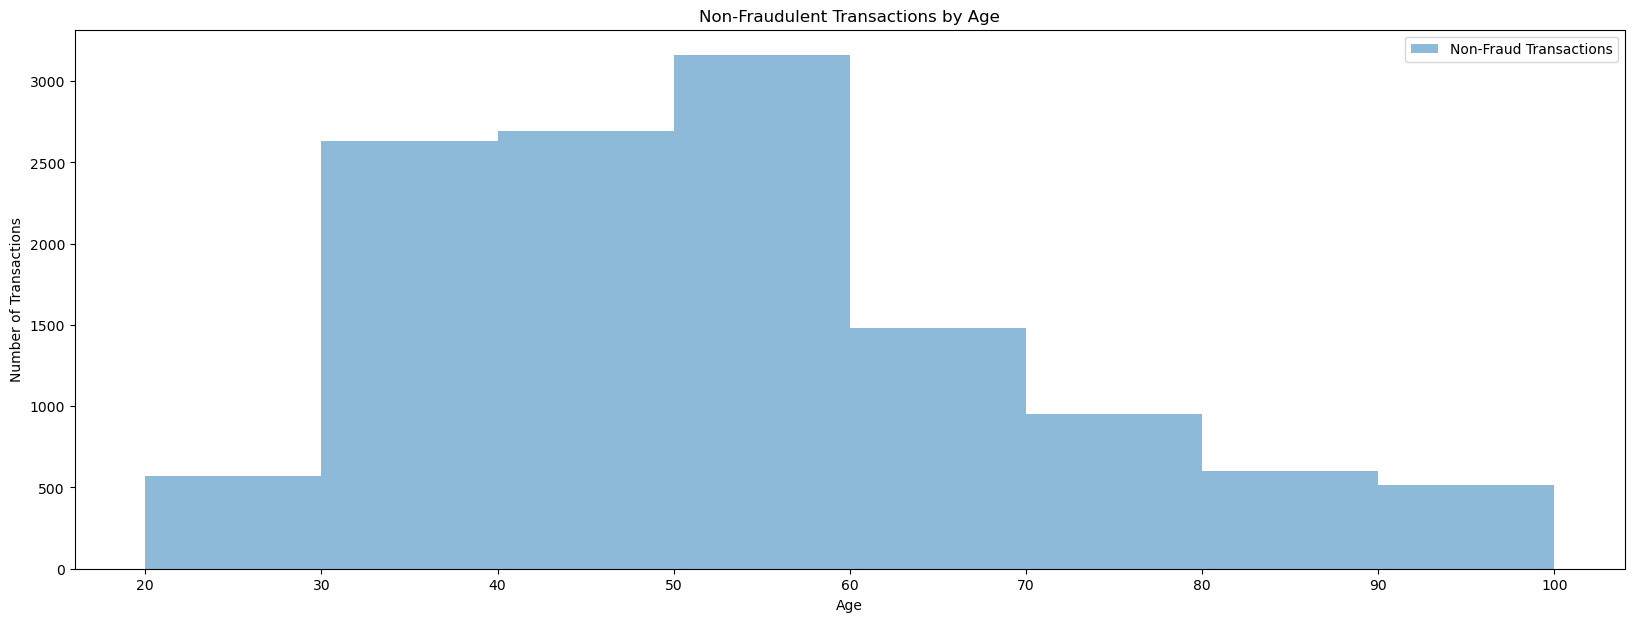

In [64]:
# Define the bins – groups of 10 years.
min_age = data['age'].min()
max_age = data['age'].max()
bins = np.arange(min_age - (min_age % 10), max_age + 10, 10)

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 1]['age'], bins=bins, alpha=0.5, label='Fraud Transactions', color='red')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Fraudulent Transactions by Age Group (Bins of 10)')
plt.legend()
plt.show()

# Create histograms for each group
plt.figure(figsize=(20, 7))
plt.hist(data[data['is_fraud'] == 0]['age'], bins=bins, alpha=0.5, label='Non-Fraud Transactions')

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Number of Transactions')
plt.title('Non-Fraudulent Transactions by Age')
plt.legend()
plt.show()

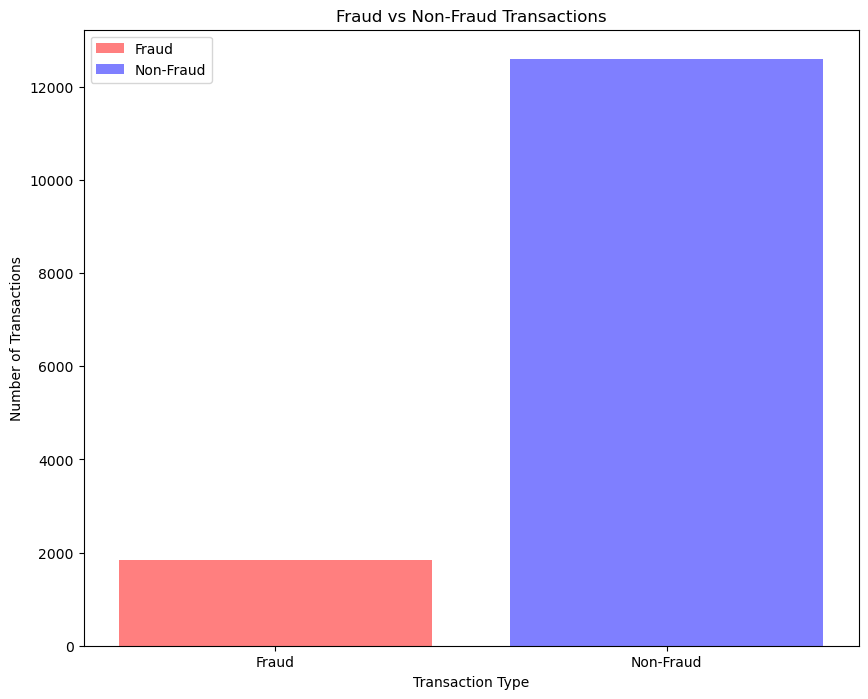

Total number of transactions: 14446


In [65]:

fraud_data = data[data['is_fraud'] == 1]
non_fraud_data = data[data['is_fraud'] == 0]
plt.figure(figsize=(10, 8))
plt.bar("Fraud", len(fraud_data), color='red', alpha=0.5, label='Fraud')
plt.bar("Non-Fraud", len(non_fraud_data), color='blue', alpha=0.5, label='Non-Fraud')
plt.xlabel('Transaction Type')
plt.ylabel('Number of Transactions')
plt.title('Fraud vs Non-Fraud Transactions')
plt.legend()
plt.show()

print(f"Total number of transactions: {len(data)}")

In [66]:
data = data.dropna(subset=['is_fraud'])
dataWTime = data
data = data.drop(columns=['transaction_year', 'transaction_month', 'transaction_day', 'transaction_hour', 'transaction_minute'])
data

,age,is_fraud,merchant_freq,city_freq,city_pop,amt,lat,long,merch_lat,merch_long,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
0,85,1.0,11,111,145,14.37,64.7556,-165.6723,65.654142,-164.722603,...,0,0,0,0,0,0,0,0,0,0
1,85,1.0,25,111,145,966.11,64.7556,-165.6723,65.468863,-165.473127,...,0,0,0,0,0,0,0,1,0,0
2,85,1.0,15,111,145,49.61,64.7556,-165.6723,65.347667,-165.914542,...,0,0,0,0,0,1,0,0,0,0
3,85,1.0,39,111,145,295.26,64.7556,-165.6723,64.445035,-166.080207,...,1,0,0,0,0,0,0,0,0,0
4,85,1.0,27,111,145,18.17,64.7556,-165.6723,65.447094,-165.446843,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,48,0.0,38,103,1302,122.00,45.8289,-118.4971,46.442439,-118.524214,...,0,0,0,0,0,0,0,0,1,0
14442,68,0.0,20,95,260,9.07,43.7857,-124.1437,42.901265,-124.995317,...,0,0,0,0,0,1,0,0,0,0
14443,51,0.0,35,59,110,104.84,44.6873,-104.4414,45.538062,-104.542117,...,1,0,0,0,0,0,0,0,0,0
14444,85,0.0,27,111,145,268.16,64.7556,-165.6723,64.081462,-165.898698,...,0,0,0,0,0,0,0,0,1,0


In [67]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# Separate features (X) and target variable (y) from the dataset
X = data.drop('is_fraud', axis=1)   # Drop the target column to get the feature matrix
y = data['is_fraud']                # Target variable indicating if a transaction is fraudulent

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test data
X_test_scaled = scaler.transform(X_test)

In [68]:
# Initialize a Logistic Regression model with a higher max_iter to ensure convergence
LogisticRegressionModel = LogisticRegression(max_iter=1000)

# Train the logistic regression model on the scaled training data
LogisticRegressionModel.fit(X_train_scaled, y_train)

# Use the trained model to predict labels for the scaled test data
y_pred = LogisticRegressionModel.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9442713741779163
Confusion Matrix:
 [[2477   25]
 [ 136  251]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      2502
         1.0       0.91      0.65      0.76       387

    accuracy                           0.94      2889
   macro avg       0.93      0.82      0.86      2889
weighted avg       0.94      0.94      0.94      2889



In [69]:
# Initialize a Random Forest Classifier
RandomForestModel = RandomForestClassifier()

# Train the model on the scaled training data
RandomForestModel.fit(X_train_scaled, y_train)

# Predict the target variable for the scaled test data
y_pred = RandomForestModel.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9781931464174455
Confusion Matrix:
 [[2483   19]
 [  44  343]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.95      0.89      0.92       387

    accuracy                           0.98      2889
   macro avg       0.97      0.94      0.95      2889
weighted avg       0.98      0.98      0.98      2889



In [70]:
# get k-fold cross validation results for Random Forest Model
k_fold_rf = KFold(n_splits=5)
cv_results_rf = cross_val_score(RandomForestModel, X_train_scaled, y_train, cv = k_fold_rf)

# print the results
print("="*50)
print("Cross-Validation Results")
print("="*50)
print("Accuracies:")    

# print the accuracies for each fold
for i, accuracy in enumerate(cv_results_rf):
    print(f"  Fold {i+1}: {accuracy:.4f}")

# print the average accuracy
print(f"\nAverage Accuracy: {cv_results_rf.mean():.4f}")
print("="*50)


Cross-Validation Results
Accuracies:
  Fold 1: 0.9714
  Fold 2: 0.9684
  Fold 3: 0.9723
  Fold 4: 0.9797
  Fold 5: 0.9723

Average Accuracy: 0.9728


In [71]:
# Initialize a Linear Regression model
LinearRegressionModel = LinearRegression()

# Train the model on the scaled training data
LinearRegressionModel.fit(X_train_scaled, y_train)

# Predict the target variable for the scaled test data
y_pred = LinearRegressionModel.predict(X_test_scaled)

# print the results
print("=" * 50)
print("Model Performance Metrics")
print("=" * 50)

# print relevant metrics
print(f"{'Mean Squared Error (MSE):':35s} {np.round(mean_squared_error(y_test, y_pred), 4)}")
print(f"{'Mean Absolute Error (MAE):':35s} {np.round(mean_absolute_error(y_test, y_pred), 4)}")
print(f"{'R² Score:':35s} {np.round(r2_score(y_test, y_pred), 4)}")

print("=" * 50)

Model Performance Metrics
Mean Squared Error (MSE):           0.0623
Mean Absolute Error (MAE):          0.1376
R² Score:                           0.4633


In [72]:
# Initialize a Decision Tree Classifier of max_depth = 1
DecisionStumpModel = DecisionTreeClassifier(max_depth = 1)

# Train the model on the scaled training data
DecisionStumpModel.fit(X_train, y_train)

# Predict the target variable for the scaled test data
y_pred = DecisionStumpModel.predict(X_test)

# print the results
print("="*50)
print("Decision Stump Results")
print("="*50)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")

# print the confusion matrix    
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")

# print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Decision Stump Results
Accuracy Score: 0.9463

Confusion Matrix:
[[2439   63]
 [  92  295]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97      2502
         1.0       0.82      0.76      0.79       387

    accuracy                           0.95      2889
   macro avg       0.89      0.87      0.88      2889
weighted avg       0.94      0.95      0.95      2889



In [73]:
# Initialize a Gradient Boosting Model
GradientBoostingModel = GradientBoostingClassifier()

# Train the model on the scaled training data
GradientBoostingModel.fit(X_train, y_train)

# Predict the target variable for the scaled test data
y_pred = GradientBoostingModel.predict(X_test)

# print the results
print("="*50)
print("Gradient Boosting Classifier Results")
print("="*50)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}\n")

# print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred), "\n")

# print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

Gradient Boosting Classifier Results
Accuracy Score: 0.9775

Confusion Matrix:
[[2486   16]
 [  49  338]] 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.95      0.87      0.91       387

    accuracy                           0.98      2889
   macro avg       0.97      0.93      0.95      2889
weighted avg       0.98      0.98      0.98      2889



Voting Classifier (ensemble) Results
Accuracy Score: 0.9772

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      2502
         1.0       0.95      0.87      0.91       387

    accuracy                           0.98      2889
   macro avg       0.97      0.93      0.95      2889
weighted avg       0.98      0.98      0.98      2889



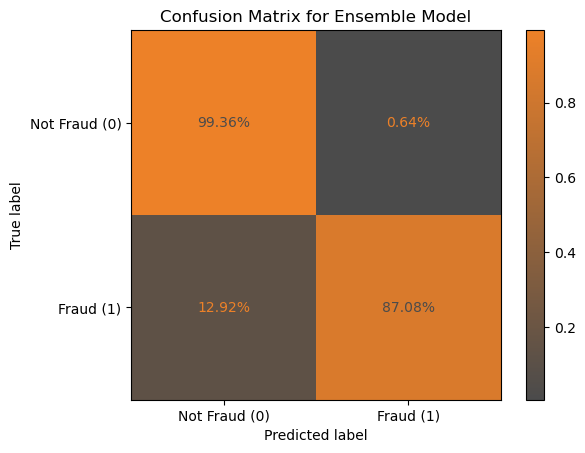

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Initialize a Random Forest Classifier, Gradient Boosting Classifier, and a Logistic Regression
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
log_reg = make_pipeline(StandardScaler(), LogisticRegression(solver='saga', max_iter=1000))

# Create a Voting Classifier ensemble with the three aforementioned models
ensemble = VotingClassifier(estimators = [
    ('rf', rf),
    ('gb', gb),
    ('log_reg', log_reg)
])

# Fit the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Predict using the ensemble model on the test data
y_pred = ensemble.predict(X_test)

# get the accuracy of the ensemble model
acc_ensemble = accuracy_score(y_test, y_pred)

# print the results
print("="*50)
print("Voting Classifier (ensemble) Results")
print("="*50)
print(f"Accuracy Score: {acc_ensemble:.4f}\n")

cm_ensemble = confusion_matrix(y_test, y_pred, normalize="true")
color_map = LinearSegmentedColormap.from_list("custom_color", ['#4B4B4B', '#ED8128'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Not Fraud (0)', 'Fraud (1)'])

_, axis = plt.subplots()
disp.plot(cmap=color_map, ax=axis, values_format='.4f')
disp.ax_.set_title("Confusion Matrix for Ensemble Model")

for text in axis.texts:
    text.set_text(f"{float(text.get_text()) * 100:.2f}%")

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred), "\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)


In [80]:
# get k-fold cross validation results for 10 folds
k_fold = KFold(n_splits=10)
cv_results = cross_val_score(ensemble, X_train, y_train, cv = k_fold)

# print the results
print("="*50)
print("Cross-Validation Results")
print("="*50)
print("Accuracies:")

# print the accuracies for each fold
for i, accuracy in enumerate(cv_results):
    print(f"  Fold {i+1}: {accuracy:.4f}")

# print the average accuracy
print(f"\nAverage Accuracy: {cv_results.mean():.4f}")
print("="*50)


Cross-Validation Results
Accuracies:
  Fold 1: 0.9697
  Fold 2: 0.9697
  Fold 3: 0.9663
  Fold 4: 0.9723
  Fold 5: 0.9706
  Fold 6: 0.9732
  Fold 7: 0.9775
  Fold 8: 0.9810
  Fold 9: 0.9714
  Fold 10: 0.9688

Average Accuracy: 0.9720


In [ ]:
# Calulate the confidence interval for the accuracy
def CI(acc, n, z=1.96):
    stddev = np.sqrt((acc * (1 - acc)) / n)
    return acc - z * stddev, min(acc + z * stddev, 1.0)
    

In [77]:
print(f"n: {len(y_test)}")
print(f"Accuracy: {acc_ensemble}")
print(f"Confidence Interval: {CI(acc_ensemble, len(y_test))}")


n: 2889
Accuracy: 0.9771547248182763
Confidence Interval: (0.9717064103625292, 0.9826030392740233)


37


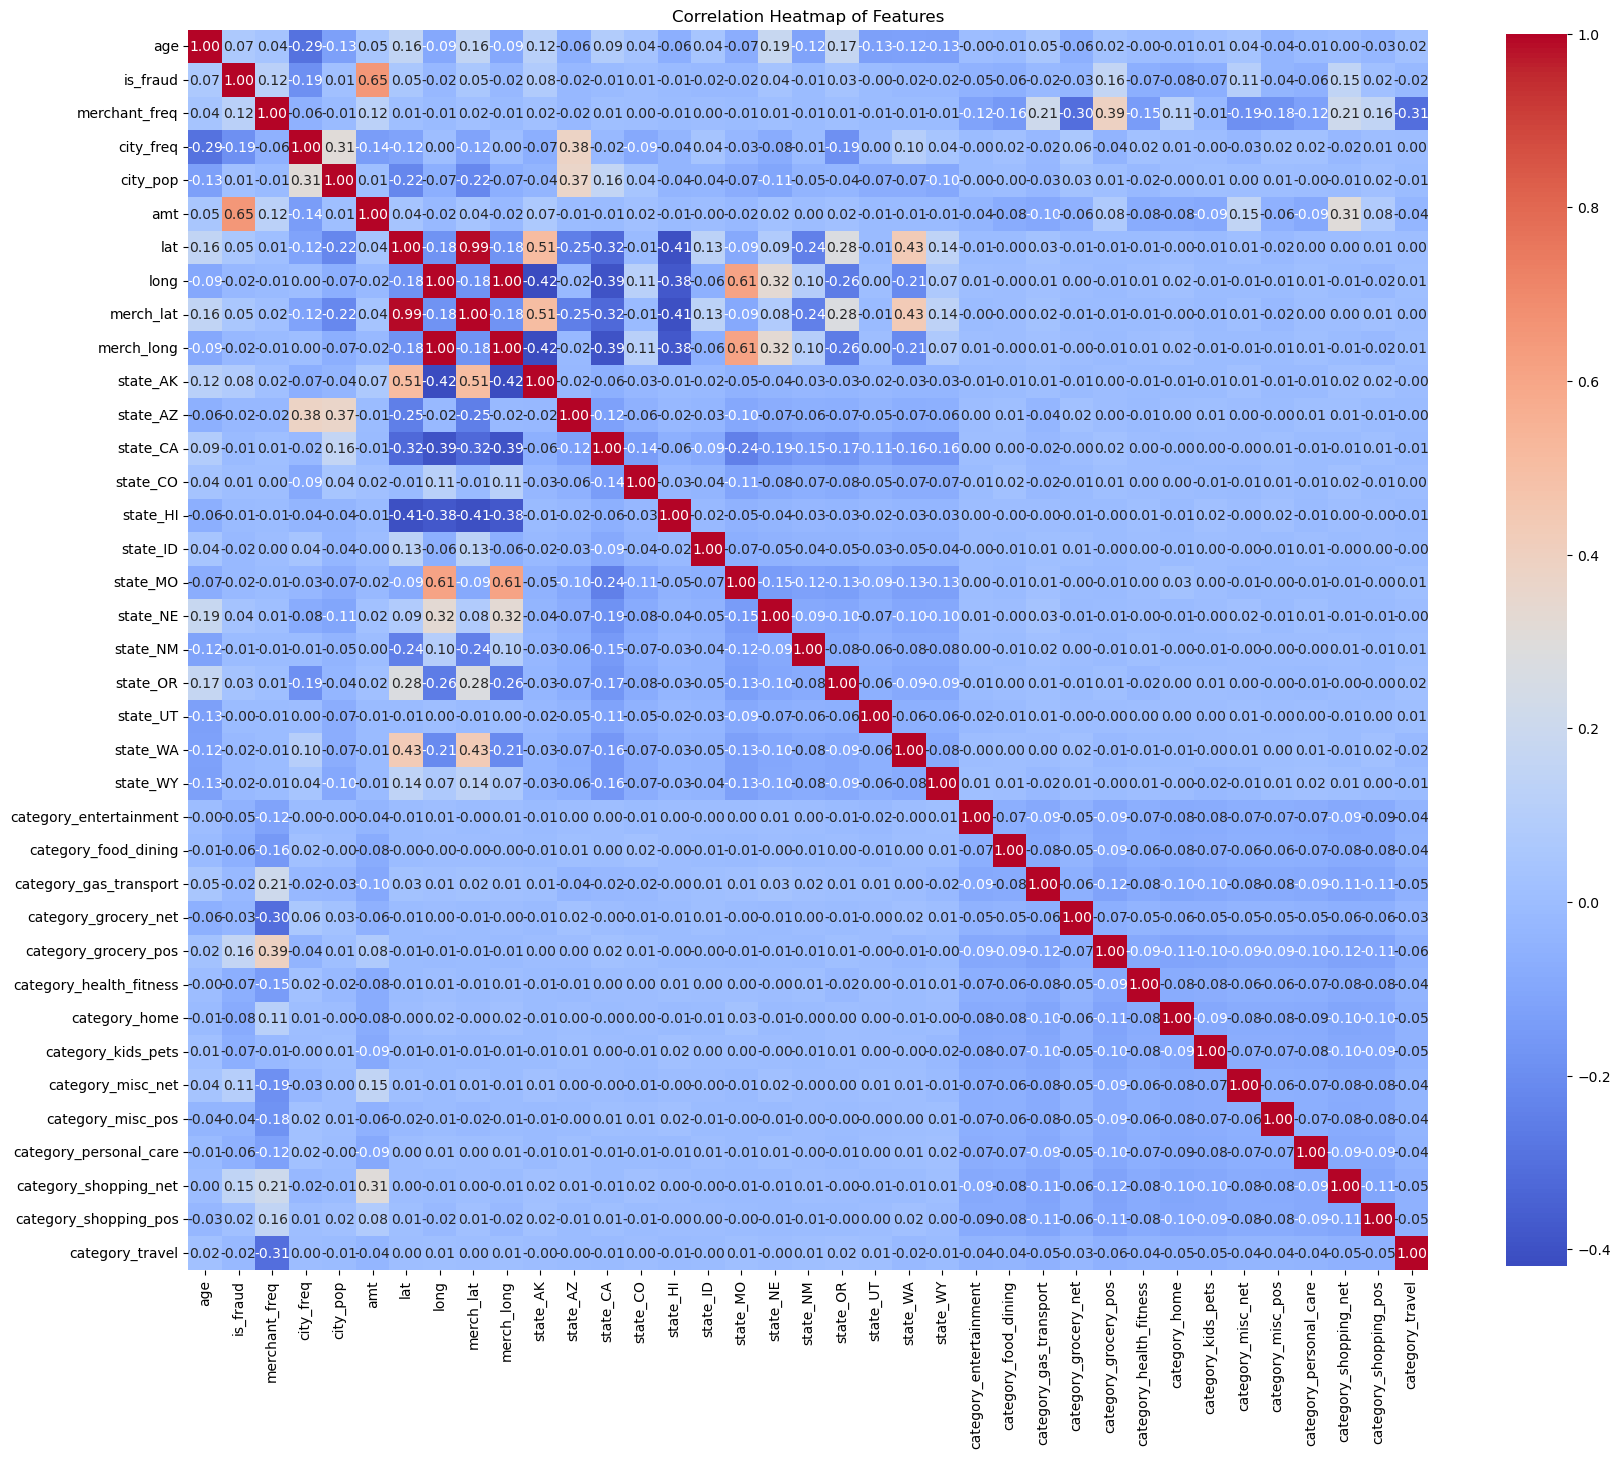

In [78]:
print(data.shape[1])
correlation = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Features")
plt.show()

2019 2020


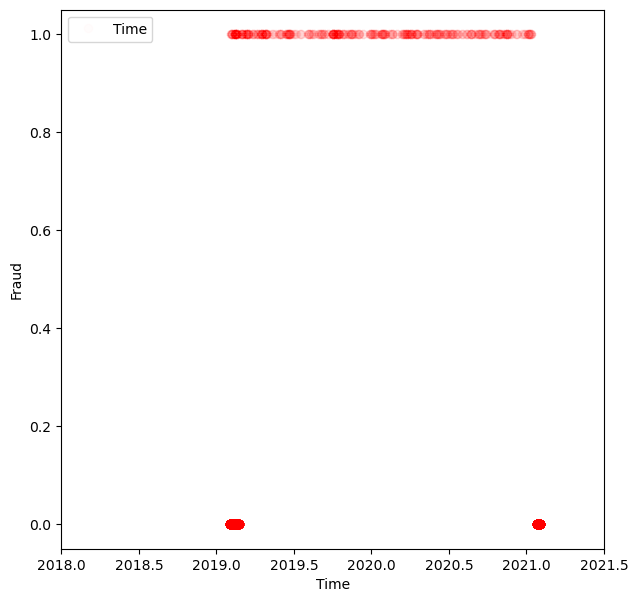

In [79]:
XYear = dataWTime["transaction_year"].values

print(min(XYear), max(XYear))

XMonth = dataWTime["transaction_month"].values
XDay = dataWTime["transaction_day"].values
XHour = dataWTime["transaction_hour"].values
XTime = np.array([XYear + XMonth / 12 + XDay / 365 + XHour / 8760]).T

YFraud = dataWTime["is_fraud"].values
plt.figure(figsize=(7, 7))
plt.plot(XTime, YFraud, "ro", label='Time', alpha=0.01)
plt.xlabel('Time')
plt.ylabel('Fraud')
plt.xlim(2018, 2021.5)
plt.legend()
plt.show()